In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import astropy.units as u

import os
gd_folder = os.getcwd()+"/../../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
op = ObjectProperties()

In [3]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7908.260159757317 Angstrom 1335.7995225325858 Angstrom 1434.877194229439 Angstrom
v_HIGH 5531.766519253978 Angstrom 849.8588260783428 Angstrom 1195.1036753366664 Angstrom


In [4]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [5]:
def get_p_chi2_map_bb(p_meas, p_err, band, specs, wid, pw):

    #Set the grid of values for the calculation. 
    psi_grid   = np.arange(0., 90., 0.5)*u.deg
    theta_grid = np.arange(1., 90., 0.5)*u.deg

    #Create the output array. We'll mask certain regions that are not technically allowed by the model. 
    p_map = np.ma.zeros((len(theta_grid), len(psi_grid)))
    p_map.mask = np.zeros(p_map.shape, dtype=bool)

    if pw.medium_type=="Gas":
        psi_2d_grid, th_2d_grid = np.meshgrid(psi_grid, theta_grid)
        p_map[:,:] = pw.p((th_2d_grid, psi_2d_grid))
    else:
        p_map[:,:] = pw.p_bb(band, theta_grid, psi_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)

    #Turn into percentages. 
    p_map *= 100
    
    #Remove angles were we would directly see the accretion disk. 
    #p_map[th_2d_grid<psi_2d_grid] = np.nan
    #p_map.mask[th_2d_grid<psi_2d_grid] = True

    #Transform it into a chi-squared map
    chi2_map = ((p_map-p_meas)/p_err)**2

    return p_map, chi2_map, psi_grid, theta_grid


In [6]:
def save_p_chi2(p_map, chi2_map, psi_grid, theta_grid, medium_type, wid, band, folder="maps"):

    if not os.path.exists(folder):
        subprocess.call(["mkdir",folder])
    
    fname = "{}_{}_{}.dat".format(medium_type, wid, band)
    for i, map in enumerate([p_map, chi2_map]):
        if i==0:
            cat = open(folder+"/p_map_"+fname,"w")
        else:
            cat = open(folder+"/chi2_map_"+fname,"w")
        np.savetxt(cat, psi_grid.value.reshape(1,len(psi_grid)))
        np.savetxt(cat, theta_grid.value.reshape(1,len(theta_grid)))
        np.savetxt(cat, map)
        cat.close()
    return

In [7]:
medium_types = ["Gas","SMC","LMC","MW"]
p_map = dict()
chi2_map = dict()
for medium_type in medium_types:
    p_map[medium_type] = dict()
    chi2_map[medium_type] = dict()
    if medium_type=="Gas":
        pw = PolWaveGas(interp_method='linear')
    else:
        pw = PolWaveDust(medium_type, interp_method='linear')
    for wid in op.wids:
        p_map[medium_type][wid] = dict()
        chi2_map[medium_type][wid] = dict()
        for band in op.pfrac[wid].keys():
            fname = "maps/chi2_map_{}_{}_{}.dat".format(medium_type, wid, band)
            if os.path.exists(fname):
                psi_grid = np.loadtxt(fname, max_rows=1)*u.deg
                theta_grid = np.loadtxt(fname, skiprows=1, max_rows=1)*u.deg
                chi2_map[medium_type][wid][band] = np.loadtxt(fname, skiprows=2)
            else:
                p_map[medium_type][wid][band], chi2_map[medium_type][wid][band], psi_grid, theta_grid = get_p_chi2_map_bb(op.pfrac[wid][band], op.epfrac[wid][band], bands.bp[band], specs, wid, pw)
                save_p_chi2(p_map, chi2_map, psi_grid, theta_grid, medium_type, wid, band)

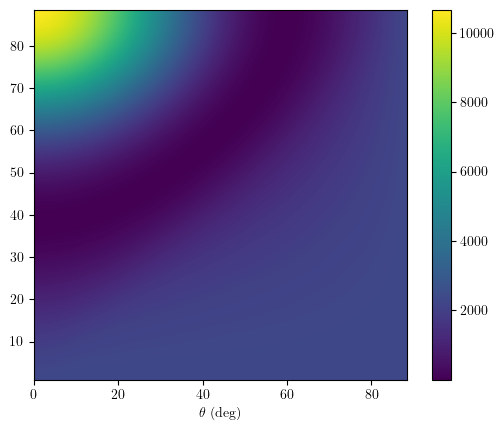

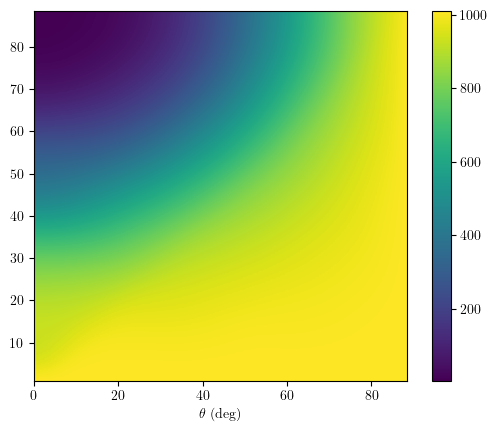

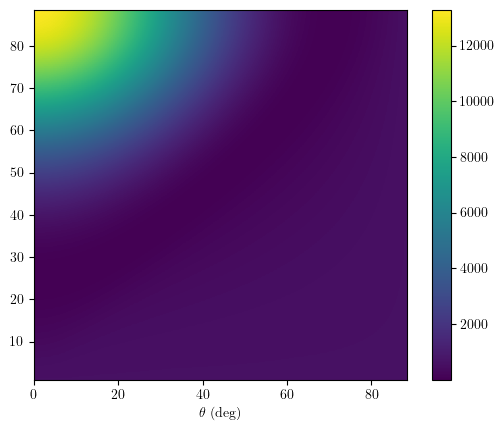

In [8]:
wid = "W0116-0505"
dust_type = "SMC"
pw = PolWaveDust(dust_type)
for band in op.filters[wid]:
    fig, ax = plt.subplots(1)
    x0 = pw.psi_grid[0].value
    x1 = pw.psi_grid[-1].value
    y0 = pw.theta_grid[0].value
    y1 = pw.theta_grid[-1].value
    cm = ax.imshow(chi2_map[dust_type][wid][band], origin='lower', extent=[x0,x1,y0,y1])
    ax.set_xlabel(r'$\psi~(\rm deg)$')
    ax.set_xlabel(r'$\theta~(\rm deg)$')
    fig.colorbar(cm)
    plt.show()

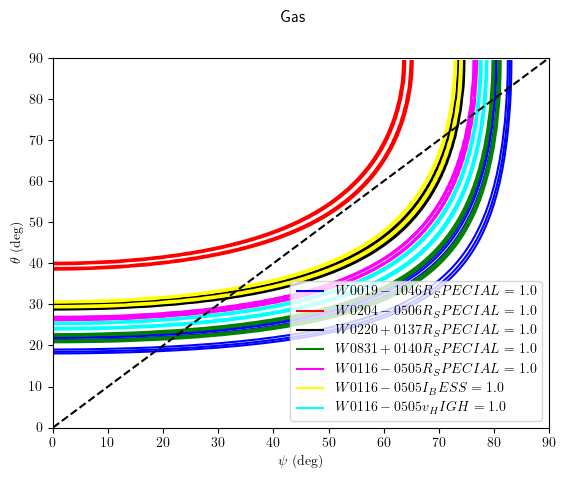

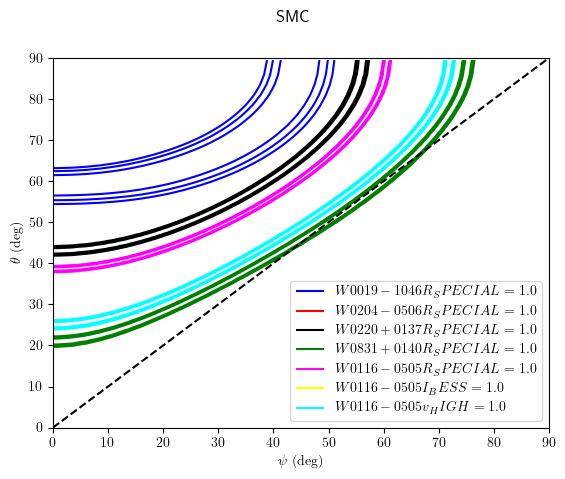

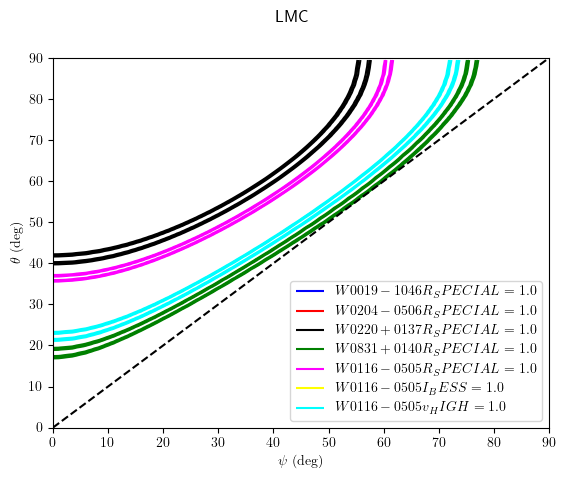

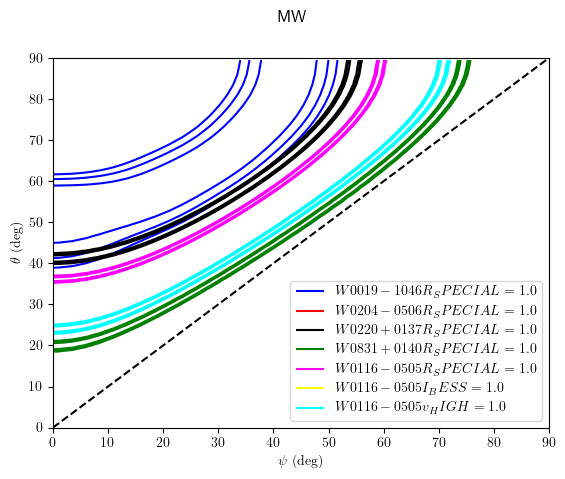

In [9]:
for medium_type in medium_types:
    fig, ax = plt.subplots(1)

    colors = ["blue", "red", "black","green","magenta","yellow","cyan"]
    h = list()
    l = list()
    j = 0
    for wid in op.wids:
        for band in op.filters[wid]:
            CS = ax.contour(psi_grid, theta_grid, chi2_map[medium_type][wid][band], levels=[1., 2., 3.], colors=colors[j])
            j+=1
            h1,l1 = CS.legend_elements(wid+" "+band)
            h.append(h1[0])
            l.append(l1[0])
    ax.plot([0.,90.],[0.,90.],'k--')
    ax.set_xlim([0.,90.])
    ax.set_ylim([0.,90.])
            
    ax.set_xlabel(r'$\psi~(\rm deg)$')
    ax.set_ylabel(r'$\theta~(\rm deg)$')
    ax.legend(h,l,loc='lower right')
    fig.suptitle(medium_type)
    plt.show()